# Plot benchmark data

**Abstract**: I have ran some benchmarking runs with svdmodel benchmark, and saved the results to a CSV file. Here, I will make some plots regarding the obtained data. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

bu2022_outdir = "./outdir_Bu2022/"
bu2023_outdir = "./outdir_Bu2023/"
outdir = "./postprocessing/"

## Preparation

Note: All the filters used in Bu2023Ye are also in Bu2022Ye (but not vice versa)

In [3]:
bu2022_files = [f for f in os.listdir(bu2022_outdir) if ".npz" in f]
bu2022_filters = [f.replace(".npz", "") for f in bu2022_files]

bu2023_files = [f for f in os.listdir(bu2023_outdir) if ".npz" in f]
bu2023_filters = [f.replace(".npz", "") for f in bu2023_files]

filters = bu2023_filters
print(filters)

['ps1__r', 'ps1__i', '2massh', '2massj', 'ps1__y', '2massks', 'ps1__g', 'ps1__z', 'sdssu']


## Quick summary values

In [4]:
my_dict = {}
for model, outdir in zip(["Bu2022", "Bu2023"], [bu2022_outdir, bu2023_outdir]):
    my_dict[model] = {}
    
    for filt in filters:
        my_dict[model][filt] = {}
        
        # Load the data
        data = np.load(outdir + f"{filt}.npz")
        data = data["chi2"]
        
        # Median:
        median = np.median(data)
        my_dict[model][filt]["median"] = median
        
        # Max:
        max_ = np.max(data)
        my_dict[model][filt]["max"] = max_
        
        # Max index:
        max_index = np.argmax(data)
        my_dict[model][filt]["max_index"] = max_index
        
        # Mean:
        mean_ = np.mean(data)
        my_dict[model][filt]["mean"] = mean_

In [44]:
which_model = "Bu2023"
result = my_dict[which_model]
print(f"Max MSE values for {which_model}:\n")
for filt, value in result.items():
    print(f"{filt}: {value['max']:.2f} ({value['max_index']})")

Max MSE values for Bu2023:

ps1__r: 2922.29 (28617)
ps1__i: 4119.19 (28617)
2massh: 5548.04 (28617)
2massj: 2854.52 (28617)
ps1__y: 8967.34 (28617)
2massks: 5248.41 (28617)
ps1__g: 6680.68 (28617)
ps1__z: 2251.11 (12752)
sdssu: 3637.89 (12752)


## Histogram

In [14]:
filters

['ps1__r',
 'ps1__i',
 '2massh',
 '2massj',
 'ps1__y',
 '2massks',
 'ps1__g',
 'ps1__z',
 'sdssu']

In [16]:
hist_kwargs = {"bins": 100, 
            "linewidth": 2,
            "density": True, 
            "histtype": "step"}

model_names = ["Bu2022", "Bu2023"]
for name in model_names:
    outdir = f"./outdir_{name}/"
    # Gather the MSE data per filter
    print("outdir")
    print(outdir)
    for filt in filters:
        # Get the data
        data = np.load(outdir + f"{filt}.npz")
        data = data["chi2"]
        data = np.log(data)
        
        # Plot the histogram
        plt.hist(data, **hist_kwargs)
        plt.title(f"{filt} ({name})", fontsize=22)
        plt.xlabel(r"$\log_{10} \chi^2$")
        plt.ylabel("Density")
        plt.savefig(f"{outdir}/MSE_{filt}.png")
        plt.close()

outdir
./outdir_Bu2022/
outdir
./outdir_Bu2023/


## Direct comparisons histograms

Make a similar plot but now combining the two models in the same plot

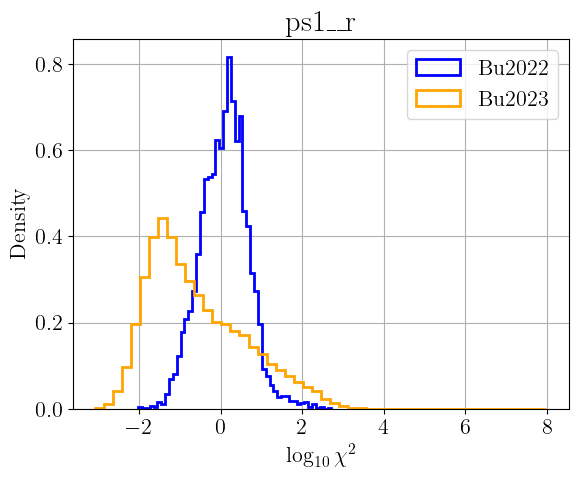

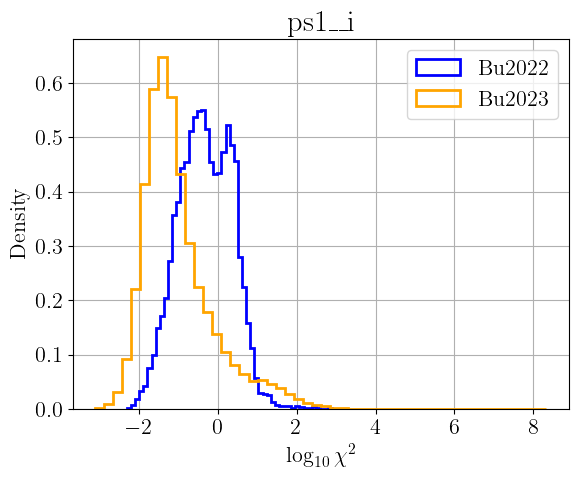

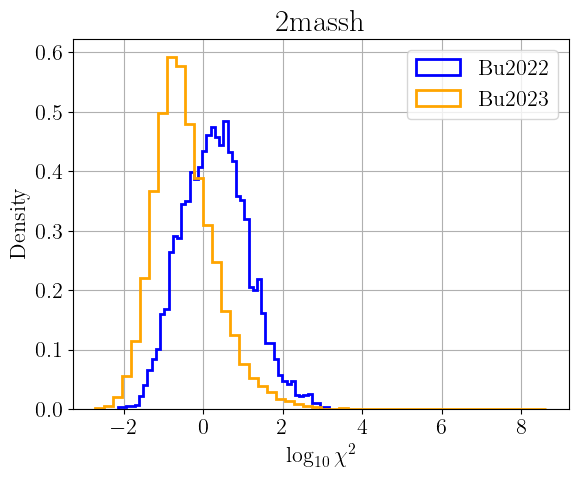

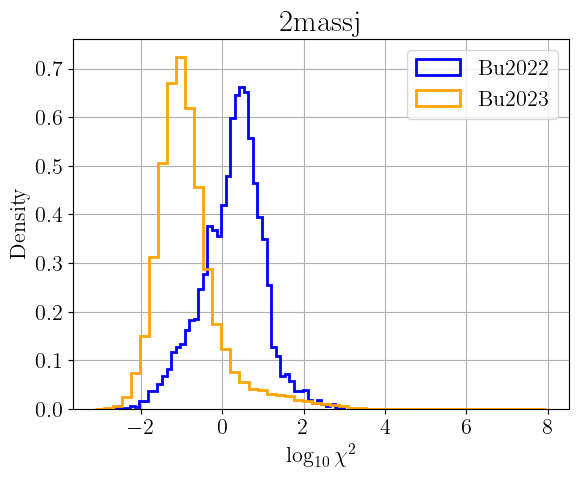

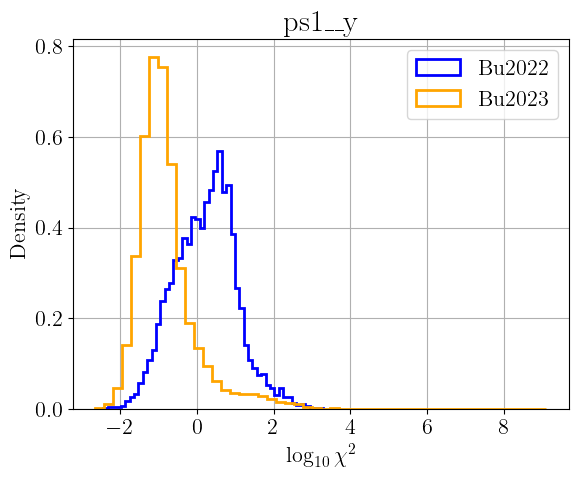

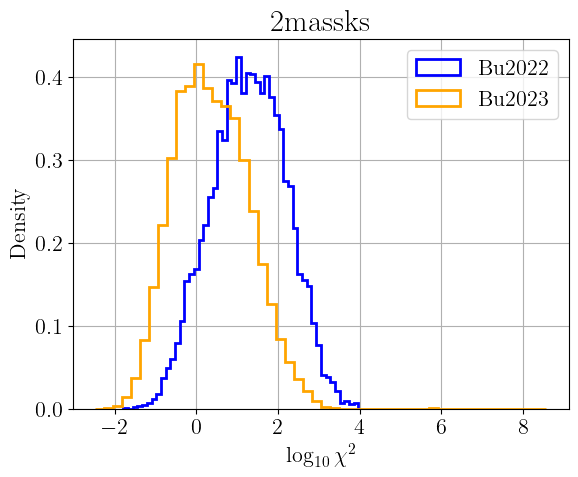

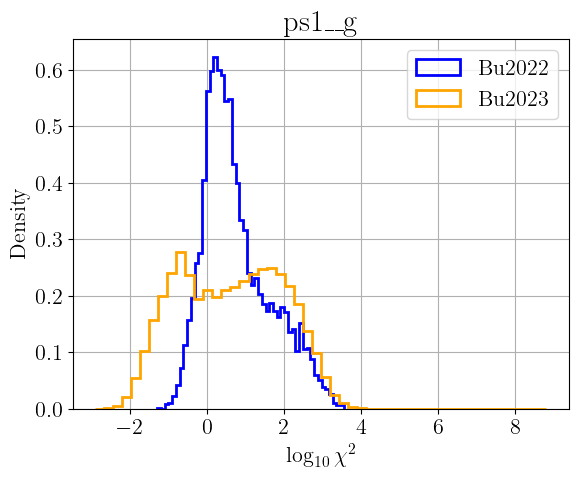

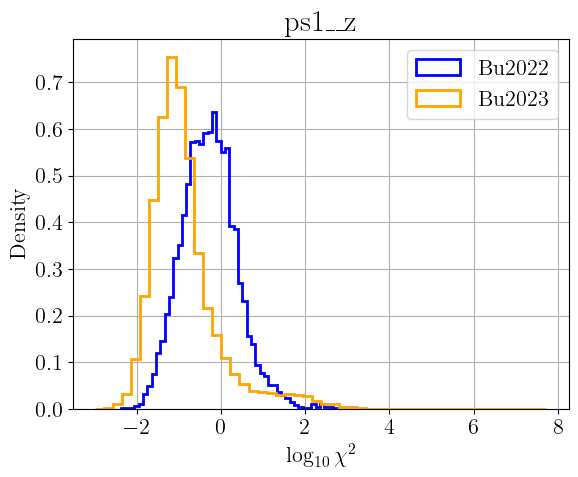

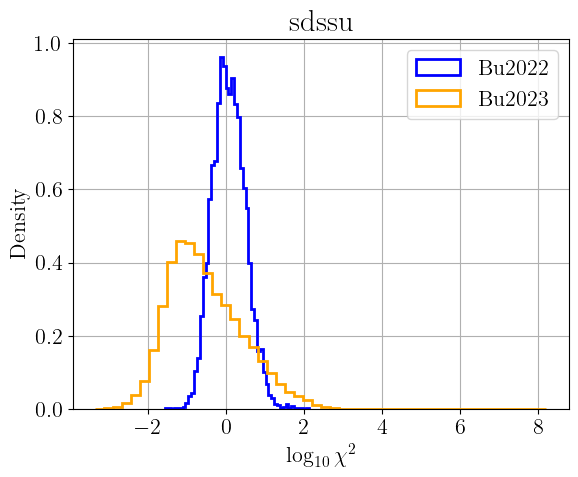

In [17]:
outdir = "./figures/"

hist_kwargs = {"bins": 50, 
            "linewidth": 2,
            "density": True, 
            "histtype": "step"}


for filt in filters:
    # Plot the histogram
    plt.hist(np.log(np.load(bu2022_outdir + f"{filt}.npz")["chi2"]), **hist_kwargs, color = "blue", label="Bu2022")
    plt.hist(np.log(np.load(bu2023_outdir + f"{filt}.npz")["chi2"]), **hist_kwargs, color = "orange", label="Bu2023")
    plt.title(f"{filt}", fontsize=22)
    plt.xlabel(r"$\log_{10} \chi^2$")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig(f"{outdir}/MSE_{filt}.png")
    plt.show()

## Discussion:

- Overall, consistent performance with previous model
- However, Bu2023Ye has a longer tail: fails for some lightcurves
    - Problem with those lightcurves? Problem because of new parameter?

## Get problematic lightcurves

Iterate over the chi squared values for Bu2023, and save per filter the indices that have chi2 above a threshold, eg 1e3

In [33]:
problematic_lcs_dict = {}

chi2_threshold = 1e3 # above this, consider it "problematic"

for filt in filters:
    # Load the data
    data = np.load(bu2023_outdir + f"{filt}.npz")
    data = data["chi2"]
    
    # Get the problematic light curves
    problematic_lcs = np.where(data > chi2_threshold)[0]
    problematic_lcs_dict[filt] = problematic_lcs
    
problematic_lcs_dict

{'ps1__r': array([12752, 18087, 28617]),
 'ps1__i': array([ 6510, 10056, 12752, 28617]),
 '2massh': array([28617]),
 '2massj': array([ 6510, 12752, 28617]),
 'ps1__y': array([28617]),
 '2massks': array([28617]),
 'ps1__g': array([12752, 18087, 28617]),
 'ps1__z': array([10056, 12752, 18087, 28617]),
 'sdssu': array([12752, 18087, 28617, 28872])}

In [34]:
def count_all_elements_occurrences(data):
    all_elements = np.concatenate(list(data.values()))
    unique_elements, counts = np.unique(all_elements, return_counts=True)
    occurrences = dict(zip(unique_elements, counts))

    return occurrences

In [35]:
count_all_elements_occurrences(problematic_lcs_dict)

{6510: 2, 10056: 2, 12752: 6, 18087: 4, 28617: 9, 28872: 1}

Out of curiosity: what would Bu2022 give?

In [41]:
# Iterate over all the chi2 and find the overall max, across filters as well, of Bu2022Ye's chi2, same for Bu2023

max_chi2 = 0
max_chi2_filter = ""

for model, outdir in zip(my_dict.keys(), [bu2022_outdir, bu2023_outdir]):
    print(f"Model: {model}")
    for filt in filters:
        # Load the data
        chi2 = np.load(outdir + f"{filt}.npz")
        chi2 = chi2["chi2"]
        this_max_chi2 = np.max(chi2)
        if this_max_chi2 > max_chi2:
            max_chi2 = this_max_chi2
            max_chi2_filter = filt
        
    print(f"Max chi2: {max_chi2} for filter {max_chi2_filter}")

Model: Bu2022
Max chi2: 53.011896453567026 for filter 2massks
Model: Bu2023
Max chi2: 8967.340605286356 for filter ps1__y
